In [1]:
import os
import pickle
import glob
import json

import numpy as np
import pandas as pd
from itertools import combinations
from scipy.optimize import curve_fit

%matplotlib inline

# Превращаем данные в .json в DataFrame

In [106]:
%%time

isotherms_data_folder = r'downloaded'
total = []

for json_file in glob.glob(isotherms_data_folder + r'\*.json'):
#     print(json_file)

    #read
    with open(json_file, 'r') as json_inp:
        json_data = json.load(json_inp)

    # check if only single substance was adsorbed
    if json_data['isotherm_data'][0]['species_data'][0]['composition'] != 1:
        continue
    
    category = json_data['category']
    adsorbent = json_data['adsorbent']['name']
    adsorbate = json_data['adsorbates'][0]['name']
    temperature = json_data['temperature']
    doi = json_data['DOI']
    p_units = json_data['pressureUnits']
    ads_units = json_data['adsorptionUnits']
    pressure = [d['pressure'] for d in json_data['isotherm_data']]
    adsorption = [d['total_adsorption'] for d in json_data['isotherm_data']]

    total.append([doi, category,
                  adsorbent, adsorbate, temperature,
                  p_units, ads_units, pressure, adsorption])

Wall time: 436 ms


In [107]:
df_sum = pd.DataFrame(total, columns=['doi', 'category',
                                      'adsorbent', 'adsorbate', 'temperature',
                                      'p_units', 'ads_units', 'pressure', 'adsorption'])

# Все возможные величины адсорбции в данном датасете

Из всех видов были выбраны mmol/g, cm3(STP)/g, mg/g, ml/g, mol/g, mmol/kg. В следующем блоке показано количество разных величин.

In [108]:
df_sum['ads_units'].value_counts()

mmol/g                        1558
cm3(STP)/g                     790
wt%                            143
molecules/unitcell             110
mg/g                            98
ml/g                            44
mmol/cm3                        38
cm3(STP)/cm3                    38
mol/mol                         18
mol/m3                          16
mol/l                           10
mg/m2                            8
kmol/m3                          7
molecules/cage                   6
                                 6
cm3/m2                           5
molecules/8 unit cells           3
molecules/Cu2 unit               3
molecules/Rh2 unit               3
Guest molecules per Cu ion       2
mmol/m2                          2
molecules/nm2                    2
g/l                              2
mol/g                            2
molecules/pore                   1
molecules/formula unit           1
mol/m2                           1
mmol/kg                          1
Name: ads_units, dty

In [109]:
df_ads = df_sum.copy()
# df3 = df3.drop(df3[df3['ads_units'] != 'mmol/g'].index)
chosen_ads_units = list(df_ads[df_ads['ads_units'] == 'mmol/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'cm3(STP)/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'mg/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'ml/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'mol/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'mmol/kg'].index) 
df_ads = df_ads[df_ads.index.isin(chosen_ads_units)]
df_ads['ads_units'].value_counts()

mmol/g        1558
cm3(STP)/g     790
mg/g            98
ml/g            44
mol/g            2
mmol/kg          1
Name: ads_units, dtype: int64

In [208]:
df_prep = df_ads.dropna()
for i, row in df_prep.iterrows():
    if row['ads_units'] == 'cm3(STP)/g' or row['ads_units'] == 'ml/g':
        try:
            new_value = np.true_divide(row['adsorption'], 22.4)
        except:
            new_value = np.nan
        df_prep.at[i,'ads_units'] = 'mmol/g'
        df_prep.at[i,'adsorption'] = new_value
    elif row['ads_units'] == 'mg/g':
        try:
            new_value = np.true_divide(row['adsorption'], 44.0)
        except:
            new_value = np.nan
        df_prep.at[i,'ads_units'] = 'mmol/g'
        df_prep.at[i,'adsorption'] = new_value
    elif row['ads_units'] == 'mol/g':
        try:
            new_value = np.multiply(row['adsorption'], 1000.0)
        except:
            new_value = np.nan
        df_prep.at[i,'ads_units'] = 'mmol/g'
        df_prep.at[i,'adsorption'] = new_value
    elif row['ads_units'] == 'mmol/kg':
        try:
            new_value = np.true_divide(row['adsorption'], 1000.0)
        except:
            new_value = np.nan
        df_prep.at[i,'ads_units'] = 'mmol/g'
        df_prep.at[i,'adsorption'] = new_value    
    elif row['ads_units'] == 'mmol/g':
        if None in row['adsorption']:
            df_prep.at[i,'adsorption'] = np.nan
df_prep = df_prep.dropna()
df_prep['ads_units'].value_counts()

mmol/g    2160
Name: ads_units, dtype: int64

In [209]:
df_prep.reset_index(inplace=True, drop=True)
df_prep.head(50)

,doi,category,adsorbent,adsorbate,temperature,p_units,ads_units,pressure,adsorption
0,10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,273,bar,mmol/g,"[0.42318, 0.676969, 1.01993, 1.36288, 1.70644,...","[0.3864669642857143, 0.6226428571428572, 0.772..."
1,10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,298,bar,mmol/g,"[0.678881, 1.35654, 1.86693, 2.54398, 3.22102,...","[0.09775803571428571, 0.17922321428571428, 0.2..."
2,10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0126608, 0.0422383, 0.0746326, 0.112661, 0....","[0.098115625, 0.2917776785714286, 0.4275924107..."
3,10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0182946, 0.0408298, 0.0816749, 0.129562, 0....","[0.09057053571428571, 0.2188401785714286, 0.33..."
4,10.1002/adfm.201300071,,CT,Carbon Dioxide,273,bar,mmol/g,"[0.0408298, 0.0999848, 0.161957, 0.218295, 0.2...","[0.18865892857142857, 0.34710982142857144, 0.4..."
5,10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0112524, 0.0816749, 0.161957, 0.221112, 0.2...","[0.098115625, 0.31944375, 0.45777232142857144,..."
6,10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0112524, 0.078858, 0.130971, 0.192943, 0.28...","[0.098115625, 0.26159642857142856, 0.349625, 0..."
7,10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0689988, 0.15914, 0.221112, 0.280266, 0.339...","[0.08554017857142858, 0.17859866071428573, 0.2..."
8,10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0422383, 0.0999848, 0.161957, 0.250689, 0.3...","[0.030208303571428573, 0.07547991071428571, 0...."
9,10.1002/adfm.201300071,,CT,Carbon Dioxide,273,bar,mmol/g,"[0.02252, 0.0661819, 0.160548, 0.253506, 0.345...","[0.04278375, 0.098115625, 0.16853839285714287,..."


In [210]:
from itertools import combinations
from scipy.optimize import curve_fit

In [211]:
def freundlich_langmuir_model(p, g_inf, K, n):
#     return (g_inf * (K*p)**n)/(1 + (K*p)**n)
      return (g_inf * (K*p)**(1/n)/(1 + (K*p)**(1/n)))

In [212]:
def langmuir_model(p, g_inf, K):
    return (g_inf * (K*p))/(1 + (K*p))

In [213]:
def freundlich_model(p, K, n):
    return (K*(p**(1/n)))

In [214]:
# def fit_isotherm(pressure, adsorption, model, model_parameters_bounds=(0.0, [np.inf, np.inf, np.inf])):
def fit_isotherm(pressure, adsorption, model, model_parameters_bounds=([0.0, 2.0, 1.11], [np.inf, 2.50, 10.0])):
    """
    curve_fit function from SciPy
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    """
# for freundlich_langmuir_model
#     model_parameters_bounds[1][0] = np.max(adsorption) + 5.0
    model_parameters_bounds[0][0] = np.max(adsorption)
    curve = [np.nan, np.nan, np.nan]
# for langmuir_model
#     curve = [np.nan, np.nan]
    try:
        curve, _ = curve_fit(f=model, xdata=pressure, ydata=adsorption,
                             bounds=model_parameters_bounds)
    except RuntimeError:
        pass
    except ValueError:
        pass
    finally:
        try:
            res = adsorption - model(np.array(pressure), *curve)
        except TypeError:
            curve = np.append(curve, np.nan)
        else:
            ss_res = np.sum(pow(res, 2))
            ss_tot = np.sum((adsorption-np.mean(adsorption))**2)
            r_squared = 1 - (ss_res / ss_tot)
            if r_squared <= 0:
                r_squared = 0
            curve = np.append(curve, r_squared)
        return curve
            

для К нахоим значение P близкое к единице в соответствующем массиве адсорбции находим значение по такому же коэффициенту и принимаем его за центральное значение диапозона К. 

In [215]:
%%time
df_prep['g_inf'], df_prep['K'], df_prep['n'], df_prep['R^2'] = \
zip(*df_prep[['pressure', 'adsorption']].apply(lambda data: fit_isotherm(data[0], data[1], freundlich_langmuir_model), axis=1))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


Wall time: 8.26 s


In [158]:
%%time
df_prep['K'], df_prep['n'], df_prep['R^2'] = \
zip(*df_prep[['pressure', 'adsorption']].apply(lambda data: fit_isotherm(data[0], data[1], freundlich_model), axis=1))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
D:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


Wall time: 6.13 s


In [167]:
%%time
df_prep['g_inf'], df_prep['K'], df_prep['R^2'] = \
zip(*df_prep[['pressure', 'adsorption']].apply(lambda data: fit_isotherm(data[0], data[1], langmuir_model), axis=1))

D:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


Wall time: 5.85 s


In [216]:
df_prep = df_prep.dropna()
df_prep.reset_index(inplace=True, drop=True)
df_prep['doi'] = "https://doi.org/"+ df_prep['doi']
# Saving to excel
df_prep.to_excel("CO2_mmol_g_L.xlsx")
df_prep['ads_units'].value_counts()

mmol/g    2145
Name: ads_units, dtype: int64

In [38]:
df_prep.head(50)

,doi,category,adsorbent,adsorbate,temperature,p_units,ads_units,pressure,adsorption,g_inf,K,n,R^2
0,https://doi.org/10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,273,bar,mmol/g,"[0.42318, 0.676969, 1.01993, 1.36288, 1.70644,...","[0.3864669642857143, 0.6226428571428572, 0.772...",1.000000,1.514074e+05,0.6,0.000000
1,https://doi.org/10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,298,bar,mmol/g,"[0.678881, 1.35654, 1.86693, 2.54398, 3.22102,...","[0.09775803571428571, 0.17922321428571428, 0.2...",1.000000,4.290606e+00,0.6,0.000000
2,https://doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0126608, 0.0422383, 0.0746326, 0.112661, 0....","[0.098115625, 0.2917776785714286, 0.4275924107...",1.000000,5.726563e+01,0.6,0.379045
3,https://doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0182946, 0.0408298, 0.0816749, 0.129562, 0....","[0.09057053571428571, 0.2188401785714286, 0.33...",1.000000,2.590612e+01,0.6,0.489118
4,https://doi.org/10.1002/adfm.201300071,,CT,Carbon Dioxide,273,bar,mmol/g,"[0.0408298, 0.0999848, 0.161957, 0.218295, 0.2...","[0.18865892857142857, 0.34710982142857144, 0.4...",1.000000,2.075001e+01,0.6,0.496314
5,https://doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0112524, 0.0816749, 0.161957, 0.221112, 0.2...","[0.098115625, 0.31944375, 0.45777232142857144,...",1.000000,1.691960e+01,0.6,0.648919
6,https://doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0112524, 0.078858, 0.130971, 0.192943, 0.28...","[0.098115625, 0.26159642857142856, 0.349625, 0...",1.000000,6.677656e+00,0.6,0.822524
7,https://doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0689988, 0.15914, 0.221112, 0.280266, 0.339...","[0.08554017857142858, 0.17859866071428573, 0.2...",1.000000,2.178592e+00,0.6,0.672552
8,https://doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0422383, 0.0999848, 0.161957, 0.250689, 0.3...","[0.030208303571428573, 0.07547991071428571, 0....",1.000000,1.054277e+00,0.6,0.734560
9,https://doi.org/10.1002/adfm.201300071,,CT,Carbon Dioxide,273,bar,mmol/g,"[0.02252, 0.0661819, 0.160548, 0.253506, 0.345...","[0.04278375, 0.098115625, 0.16853839285714287,...",1.000000,8.660772e-01,0.6,0.914206


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B439088D88>]],
      dtype=object)

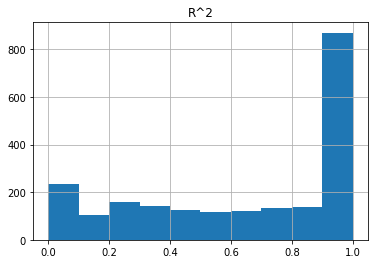

In [189]:
df_prep.hist(column='R^2')

In [3]:
df_prep = pd.read_csv("h2_iso.csv")

In [4]:
df_set = df_prep.copy()
# df_set = df_set.drop_duplicates(subset=['g_inf', 'K', 'n', 'adsorbent'])
df_set = df_set.drop_duplicates(subset=['g_inf', 'K', 'adsorbent'])
df_set['ads_units'].value_counts()

wt%       2101
mmol/g    1779
Name: ads_units, dtype: int64

# Построение графиков изотерм выбранного MOF из датасета

In [23]:
import ipywidgets as widgets
df_set_drpdwn = widgets.Dropdown(
    options=list(df_set.drop_duplicates(subset=['adsorbent'])['adsorbent']),
    description='MOF:',
    disabled=False,
)
df_set_drpdwn

Dropdown(description='MOF:', options=('CuBTC', 'IRMOF-1', '[Zn(bdc)(ted)0.5]*2DMF*0.2H2O', '[Cu(bdc)(ted)0.5]*…

In [26]:
subset = df_set[df_set['adsorbent']== df_set_drpdwn.value]
subset

,Unnamed: 0,doi,category,adsorbent,adsorbate,temperature,p_units,ads_units,pressure,adsorption,g_inf,K,n,R^2
2,2,https://doi.org/https://doi.org/https://doi.or...,NaN,IRMOF-1,Hydrogen,77,bar,wt%,"[0.310676, 2.12862, 3.82065, 5.82457, 10.3151,...","[0.019531, 1.61819, 2.26167, 2.8857, 3.62699, ...",4.713120,2.0,2.352852,0.570155
3,3,https://doi.org/https://doi.org/https://doi.or...,NaN,IRMOF-1,Hydrogen,87,bar,wt%,"[0.310676, 2.30003, 2.60646, 3.06914, 3.83976,...","[0.019531, 1.11139, 1.26737, 1.40388, 1.64764,...",4.177420,2.0,4.873251,0.265262
4,4,https://doi.org/https://doi.org/https://doi.or...,NaN,IRMOF-1,Hydrogen,200,bar,wt%,"[0.310676, 3.73327, 6.99871, 14.4665, 27.9985,...","[0.019531, 0.068681, 0.166545, 0.26492, 0.5492...",0.845750,2.0,7.071896,0.097846
5,5,https://doi.org/https://doi.org/https://doi.or...,NaN,IRMOF-1,Hydrogen,298,bar,wt%,"[0.310676, 5.13617, 7.93711, 12.4495, 17.8969,...","[0.019531, 0.000625751, 0.0204602, 0.0599963, ...",0.340276,2.0,9.999999,0.000000
24,24,https://doi.org/https://doi.org/https://doi.or...,NaN,IRMOF-1,Hydrogen,298,bar,wt%,"[4.88372, 7.95866, 10.491, 30.0258, 58.9664, 6...","[0.0126419, 0.0283765, 0.0292165, 0.0993665, 0...",0.170696,2.0,10.000000,0.035285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3827,3827,https://doi.org/https://doi.org/https://doi.or...,NaN,IRMOF-1,Hydrogen,298,bar,mmol/g,"[1.34825, 24.3517, 35.3834, 42.6098, 50.1868, ...","[0.0863309, 0.230216, 0.402878, 0.561151, 0.79...",5.338130,2.0,10.000000,0.000000
3828,3828,https://doi.org/https://doi.org/https://doi.or...,NaN,IRMOF-1,Hydrogen,298,bar,mmol/g,"[1.34825, 24.3781, 35.25, 42.6793, 50.2803, 65...","[0.0863309, 0.0719424, 0.115108, 0.143885, 0.2...",0.964029,2.0,10.000000,0.000000
3829,3829,https://doi.org/https://doi.org/https://doi.or...,NaN,IRMOF-1,Hydrogen,298,bar,mmol/g,"[1.34825, 24.3421, 35.3786, 42.6026, 50.1772, ...","[0.0863309, 0.28777, 0.431655, 0.604317, 0.848...",5.366910,2.0,10.000000,0.000000
3830,3830,https://doi.org/https://doi.org/https://doi.or...,NaN,IRMOF-1,Hydrogen,298,bar,mmol/g,"[1.34825, 24.3733, 35.4218, 42.6673, 50.2731, ...","[0.0863309, 0.100719, 0.172662, 0.215827, 0.27...",0.978417,2.0,10.000000,0.000000


In [25]:
subset_drpdwn = widgets.Dropdown(
    options=subset.index.values.tolist(),
    description='Choose',
    disabled=False,
)
subset_drpdwn

Dropdown(description='Choose', options=(0, 1, 6, 7, 8, 9, 37, 47, 350, 351, 365, 383, 384, 440, 441, 447, 520,…

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('int64'), dtype('<U51')) -> None

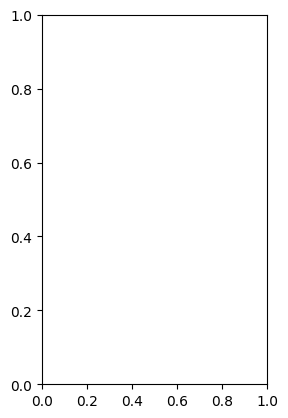

In [28]:
mof_ind = subset_drpdwn.value
plt.subplot(121)
plt.plot(df_set.loc[mof_ind, 'pressure'], 1000*np.array(df_set.loc[mof_ind, 'adsorption']), 'ro--')
plt.title(df_set.loc[mof_ind, 'adsorbent'])
plt.ylabel(df_set.loc[mof_ind, 'doi'])
plt.subplot(122)
plt.plot(df_set.loc[mof_ind, 'pressure'], df_set.loc[mof_ind, 'adsorption'], 'bo--')
plt.title(df_set.loc[mof_ind, 'adsorbent'])
plt.show()